# **Introduction**

This homework explores image classification models described in the lecture/textbook. The exercise below repeats the major steps in the dog/cat classification but on a different dataset. 

The dataset used for this homework is described in the paper "Food/Non-food Image Classification and Food Categorization using Pre-Trained GoogLeNet Model", Ashutosh Singla, Lin Yuan, Touradj Ebrahimi, MADiMa '16: Proceedings of the 2nd International Workshop on Multimedia Assisted Dietary ManagementOctober 2016 Pages 3–11

Link to the paper: https://dl.acm.org/doi/10.1145/2986035.2986039

# **Dataset**

The official source of this dataset is hosted on EPFl's website but does not seem to be available. Thus we will use the version posted on Kaggle: https://www.kaggle.com/trolukovich/food5k-image-dataset


---

**You must use this specific Kaggle dataset (there are others) and preserve the directory structure of the dataset**


---
You will need to register on Kaggle as described in the textbook on pages 212-213 (or just follow Kaggle instructions).  

The dataset contains 2500 food and 2500 non-food images, for the task of food/non-food classification. The whole dataset is divided in three parts: training, validation and evaluation. 

Each directory has food/non-food subdirectory containing images of the corresponding class. 

---
In the following code cell define the path to the directory containing the dataset. When I'll be running the notebook, I'll modify the path to the directory on my drive.

You also need to define a path to the secret dataset I'll use for additional testing of your models. This dataset will have the same structure:
  - root directory
    - food
    - non-food. 

The data will be independent of Food-5K. Your code needs to compute the accuracy of food/non-food classification on this dataset. For the sake of development, create the directory structure and copy some images into those directories.


In [45]:
!rm -r ./food5k-image-dataset.zip ./data 
!pip install kaggle
!kaggle datasets download -d trolukovich/food5k-image-dataset
!mkdir ./data
!unzip ./food5k-image-dataset -d ./data

You should consider upgrading via the '/home/max/tmp/homework/venv/bin/python3.9 -m pip install --upgrade pip' command.
 99%|███████████████████████████████████████▊| 424M/426M [00:07<00:00, 59.2MB/s]
100%|████████████████████████████████████████| 426M/426M [00:07<00:00, 59.7MB/s]
Archive:  ./food5k-image-dataset.zip
  inflating: ./data/evaluation/food/0.jpg  
  inflating: ./data/evaluation/food/1.jpg  
  inflating: ./data/evaluation/food/10.jpg  
  inflating: ./data/evaluation/food/100.jpg  
  inflating: ./data/evaluation/food/101.jpg  
  inflating: ./data/evaluation/food/102.jpg  
  inflating: ./data/evaluation/food/103.jpg  
  inflating: ./data/evaluation/food/104.jpg  
  inflating: ./data/evaluation/food/105.jpg  
  inflating: ./data/evaluation/food/106.jpg  
  inflating: ./data/evaluation/food/107.jpg  
  inflating: ./data/evaluation/food/108.jpg  
  inflating: ./data/evaluation/food/109.jpg  
  inflating: ./data/evaluation/food/11.jpg  
  inflating: ./data/evaluation/food/110.jpg

In [2]:
# define the path to the food/non-food dataset
import pathlib

dataset_path = pathlib.Path("./data")
secret_dataset_path = pathlib.Path("./data")


# **Task 1**

In this task you have to design and train a small CNN model following the procedure described in Chapter 8 of the book. 

Requirements:
- use at least 256 x 256 image resolution
- do not use exactly the same architecture as in the book, adapt the CNN to match increased image resolution
- (recommendation) in preprocessing, consider preserving the aspect ratio of the original image while scaling
- use data augmentation, add at least one adiditional augmentation method compared to the book (see https://www.tensorflow.org/tutorials/images/data_augmentation)
- add RandomColorDistortion augmentation (see https://towardsdatascience.com/writing-a-custom-data-augmentation-layer-in-keras-2b53e048a98)
- Train the model, display training and validation loss/accuracy curves
- Evaluate the effect of adding dropout layers after convolutional layers. You may try various options (at least one dropout layer/no dropout), evaluate the effect of validation/test accuracy, document the experiment in the report and then keep the best model here.
- **Save the model on the disk** This is your baseline model, everything else is compared to the results obatined by this model.

### Loading The Data

In [3]:
# create the datasets
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (256, 256)

train_dataset = image_dataset_from_directory(
    dataset_path / "training",
    image_size=IMG_SIZE,
    batch_size=16,
    crop_to_aspect_ratio=True,
)
validation_dataset = image_dataset_from_directory(
    dataset_path / "validation",
    image_size=IMG_SIZE,
    batch_size=16,
    crop_to_aspect_ratio=True,
)
test_dataset = image_dataset_from_directory(
    dataset_path / "evaluation",
    image_size=IMG_SIZE,
    batch_size=16,
    crop_to_aspect_ratio=True,
)


Found 3000 files belonging to 2 classes.


2022-03-10 11:16:38.602351: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 11:16:39.040663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9540 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


### Creating the Data Augementation Layers

In [48]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

class RandomColorDistortion(keras.layers.Layer):
    def __init__(self, contrast_range=[0.9, 1.1], 
                 brightness_delta=[-0.1, 0.1], **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
    
    def call(self, images, training=None):
        if not training:
            return images
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        
        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        # images = tf.clip_by_value(images, 0, 1)
        return images
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "contrast_range": self.contrast_range,
            "brightness_delta": self.brightness_delta,
        })
        return config

# creating and testing the data augementation
def data_augementation():
    return tf.keras.Sequential(
        [
            tf.keras.layers.RandomTranslation(0.1, 0.1),
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.2),
            RandomColorDistortion(
               contrast_range=[0.8, 1.2], 
                brightness_delta=[-0.1, 0.1]
            )
        ]
    )


#### Plotting the Augemention Layers

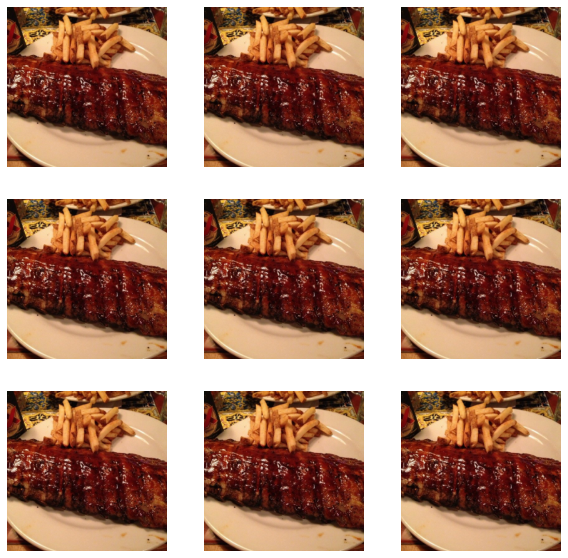

In [49]:
import matplotlib.pyplot as plt

# plotting the data augmentation and the color distortion
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        # augmented_images = RandomColorDistortion(
        #     contrast_range=[0.5, 1.5], 
        #     brightness_delta=[-0.2, 0.2]
        # )(images, training=True)
        augmented_images = data_augementation()(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


### Building the Models

In [6]:
from tensorflow import keras
from tensorflow.keras import layers


def build_model(resolution: tuple, dropout_num: int = 0):

    # set the input dimensions
    inputs = keras.Input(shape=(*resolution, 3))

    # add the data augementation
    x = data_augementation()(inputs)

    # rescale the neural net
    x = layers.Rescaling(1.0 / 255)(x)

    # common layers
    dropout_num_t = dropout_num
    for filt in [32, 64, 128, 256]:
        x = layers.Conv2D(filters=filt, kernel_size=3, activation="relu")(x)
        if dropout_num_t > 1:
            x = layers.Dropout(0.5)(x)
            dropout_num_t -= 1
        
        x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)
    
    if dropout_num > 0:
        x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model


def build_callbacks(save_name):
    return [
        # tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10), 
        keras.callbacks.ModelCheckpoint(
            filepath=save_name, save_best_only=True, monitor="val_loss"
        )
    ]


In [7]:

model = build_model(IMG_SIZE)

### Training the Model

In [8]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=build_callbacks("part_1.keras")
)

Epoch 1/30


2022-03-10 08:34:36.337289: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-03-10 08:34:36.812264: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-10 08:34:36.814206: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


188/188 [==============================] - 8s 28ms/step - loss: 0.6314 - accuracy: 0.7227 - val_loss: 0.4770 - val_accuracy: 0.7850
Epoch 2/30
188/188 [==============================] - 5s 27ms/step - loss: 0.4851 - accuracy: 0.7947 - val_loss: 0.4155 - val_accuracy: 0.8220
Epoch 3/30
188/188 [==============================] - 5s 27ms/step - loss: 0.4534 - accuracy: 0.8080 - val_loss: 0.4704 - val_accuracy: 0.7630
Epoch 4/30
188/188 [==============================] - 5s 27ms/step - loss: 0.4230 - accuracy: 0.8250 - val_loss: 0.4959 - val_accuracy: 0.8150
Epoch 5/30
188/188 [==============================] - 5s 26ms/step - loss: 0.4091 - accuracy: 0.8397 - val_loss: 0.3253 - val_accuracy: 0.8660
Epoch 6/30
188/188 [==============================] - 5s 26ms/step - loss: 0.3851 - accuracy: 0.8400 - val_loss: 1.0874 - val_accuracy: 0.6890
Epoch 7/30
188/188 [==============================] - 5s 26ms/step - loss: 0.3630 - accuracy: 0.8533 - val_loss: 0.3632 - val_accuracy: 0.8570
Epoch 8/30

### Analyzing the Model

#### Evaluating the Model on Test Set of Data

In [9]:
custom_objects = {"RandomColorDistortion": RandomColorDistortion,}
with keras.utils.custom_object_scope(custom_objects):
    test_model = keras.models.load_model("part_1.keras")

test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


63/63 [==============================] - 1s 13ms/step - loss: 0.2816 - accuracy: 0.8930
Test accuracy: 0.893


#### Plotting the Training Loss v. Epoch

In [10]:
import matplotlib.pyplot as plt

def plot_history(h):
    acc = h.history["accuracy"]
    val_acc = h.history["val_accuracy"]
    loss = h.history["loss"]
    val_loss = h.history["val_loss"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

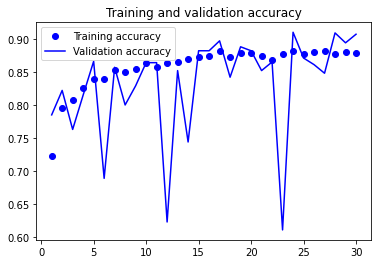

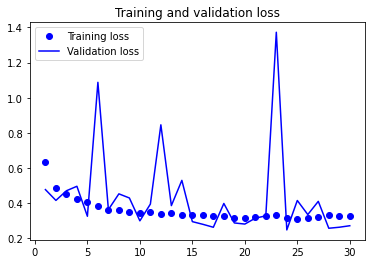

In [11]:
plot_history(history)

### Trying Different Dropouts

In [12]:
for drop_out in range(0, 4):
    _model = build_model(IMG_SIZE, drop_out)
    # Training for just 10 epochs based on plots above
    _model.fit(train_dataset, epochs=30, validation_data=validation_dataset, verbose=0)
    test_loss, test_acc = _model.evaluate(test_dataset)
    print(f"Dropout Layers: {drop_out} accuracy: {test_acc:.3f}")


63/63 [==============================] - 1s 13ms/step - loss: 1.0361 - accuracy: 0.7640
Dropout Layers: 0 accuracy: 0.764
63/63 [==============================] - 1s 13ms/step - loss: 1.8313 - accuracy: 0.7650
Dropout Layers: 1 accuracy: 0.765
63/63 [==============================] - 1s 12ms/step - loss: 0.3707 - accuracy: 0.8740
Dropout Layers: 2 accuracy: 0.874
63/63 [==============================] - 1s 13ms/step - loss: 0.6530 - accuracy: 0.7440
Dropout Layers: 3 accuracy: 0.744


The best results came from one dropout layer. Retraining and saving the model with one dropout layer below

In [13]:
build_model(IMG_SIZE, dropout_num=2).fit(train_dataset, epochs=30, validation_data=validation_dataset, verbose=2, callbacks=build_callbacks("part_1.best.keras"))

Epoch 1/30
188/188 - 7s - loss: 0.6662 - accuracy: 0.6983 - val_loss: 0.6098 - val_accuracy: 0.6870 - 7s/epoch - 35ms/step
Epoch 2/30
188/188 - 6s - loss: 0.5111 - accuracy: 0.7820 - val_loss: 0.4403 - val_accuracy: 0.8160 - 6s/epoch - 29ms/step
Epoch 3/30
188/188 - 5s - loss: 0.4664 - accuracy: 0.8050 - val_loss: 0.4590 - val_accuracy: 0.7710 - 5s/epoch - 29ms/step
Epoch 4/30
188/188 - 6s - loss: 0.4471 - accuracy: 0.8063 - val_loss: 0.4008 - val_accuracy: 0.8230 - 6s/epoch - 29ms/step
Epoch 5/30
188/188 - 6s - loss: 0.4176 - accuracy: 0.8233 - val_loss: 0.3623 - val_accuracy: 0.8390 - 6s/epoch - 29ms/step
Epoch 6/30
188/188 - 5s - loss: 0.4054 - accuracy: 0.8397 - val_loss: 0.3441 - val_accuracy: 0.8610 - 5s/epoch - 29ms/step
Epoch 7/30
188/188 - 5s - loss: 0.3851 - accuracy: 0.8473 - val_loss: 0.3165 - val_accuracy: 0.8590 - 5s/epoch - 29ms/step
Epoch 8/30
188/188 - 6s - loss: 0.3676 - accuracy: 0.8563 - val_loss: 0.3070 - val_accuracy: 0.8750 - 6s/epoch - 29ms/step
Epoch 9/30
188/1

# **Task 2**

- Load the model from the disk (required so that I can test without retraining)
- Assess accuracy on the test set
- Assess accuracy on the secret dataset (I'll use your code but my own dataset here, do not forget to use `secret_dataset_path`)
- In the report comment on the architecture choices you made, effect of drop out layers.


### Loading the Model

In [16]:
# your solution goes here
custom_objects = {"RandomColorDistortion": RandomColorDistortion,}
with keras.utils.custom_object_scope(custom_objects):
    best_model = keras.models.load_model("part_1.best.keras")


### Assess accuracy on the test set

In [17]:
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 13ms/step - loss: 0.2732 - accuracy: 0.8790
Test accuracy: 0.879


### Assess accuracy on the secret dataset

In [18]:
secret_test_dataset = image_dataset_from_directory(
    secret_dataset_path / "evaluation",
    image_size=IMG_SIZE,
    batch_size=32,
    crop_to_aspect_ratio=True,
)

test_loss, test_acc = best_model.evaluate(secret_test_dataset)
print(f"Secret test accuracy: {test_acc:.3f}")

Found 1000 files belonging to 2 classes.
32/32 [==============================] - 1s 20ms/step - loss: 0.2732 - accuracy: 0.8790
Secret test accuracy: 0.879


# **Task 3**

Here you need to use RESNET layers to perform the same classification task.

Requirements:
- double the number of convolution layers compared to the CNN model above (double the depth)
- train for a number of epochs (sufficiently long to match or beat the baseline)
- Replace the CNN layers by RESNET layers, train for the same number of epochs. Note the accuracy and training/validation curves. If needed train until matching/beating the baseline performance.
- **Save the model on the disk**



### Doubling the # of Conv Layers

In [19]:

def build_model_3(resolution, dropout_num=2, ):
    # set the input dimensions
    inputs = keras.Input(shape=(*resolution, 3))

    # add the data augementation
    x = data_augementation()(inputs)

    # rescale the neural net
    x = layers.Rescaling(1.0 / 255)(x)

    # common layers
    dropout_num_t = dropout_num
    layer_filts = [5, 6, 7, 8, 9, 10, 11, 12,]
    for i, filt in enumerate(layer_filts):
        x = layers.Conv2D(filters=2 ** filt, kernel_size=3, activation="relu", padding="same")(x)
        if dropout_num_t > 1:
            x = layers.Dropout(0.5)(x)
            dropout_num_t -= 1        
        if i < len(layer_filts) - 1:
            x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Flatten()(x)
    
    if dropout_num > 0:
        x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model
    

### Training the Model

In [20]:
class HaltCallback(tf.keras.callbacks.Callback):
    def __init__(
        self,
        stop_baseline,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self._stop_baseline = stop_baseline

    def on_epoch_end(self, epoch, logs={}):
        if logs.get("val_accuracy") >= self._stop_baseline:
            self.model.stop_training = True


build_model_3(IMG_SIZE, dropout_num=2).fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    verbose=2,
    callbacks=HaltCallback(0.8880),
)


Epoch 1/30
188/188 - 27s - loss: 31.8549 - accuracy: 0.5093 - val_loss: 0.6929 - val_accuracy: 0.5120 - 27s/epoch - 144ms/step
Epoch 2/30
188/188 - 24s - loss: 0.7124 - accuracy: 0.6217 - val_loss: 0.6218 - val_accuracy: 0.7630 - 24s/epoch - 130ms/step
Epoch 3/30
188/188 - 24s - loss: 0.6280 - accuracy: 0.7420 - val_loss: 0.4998 - val_accuracy: 0.8160 - 24s/epoch - 130ms/step
Epoch 4/30
188/188 - 24s - loss: 0.5386 - accuracy: 0.7850 - val_loss: 0.4808 - val_accuracy: 0.7580 - 24s/epoch - 130ms/step
Epoch 5/30
188/188 - 24s - loss: 0.4876 - accuracy: 0.8037 - val_loss: 0.4023 - val_accuracy: 0.8440 - 24s/epoch - 130ms/step
Epoch 6/30
188/188 - 24s - loss: 0.4556 - accuracy: 0.8107 - val_loss: 0.5059 - val_accuracy: 0.7770 - 24s/epoch - 130ms/step
Epoch 7/30
188/188 - 24s - loss: 0.4330 - accuracy: 0.8220 - val_loss: 0.6683 - val_accuracy: 0.6460 - 24s/epoch - 129ms/step
Epoch 8/30
188/188 - 24s - loss: 0.4434 - accuracy: 0.8220 - val_loss: 0.4543 - val_accuracy: 0.8500 - 24s/epoch - 13

### Replace the CNN with ResNet Layers

In [50]:
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D,
    ReLU,
    BatchNormalization,
    Add,
    Flatten,
)

from tensorflow.keras import optimizers


def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn


def residual_block(x, downsample, filters):
    y = Conv2D(
        kernel_size=3,
        strides=(1 if not downsample else 2),
        filters=filters,
        padding="same",
    )(x)
    y = relu_bn(y)
    y = Conv2D(
        kernel_size=3, strides=1, filters=filters, padding="same"
    )(y)
    if downsample:
        x = Conv2D(
            kernel_size=1, strides=2, filters=filters, padding="same"
        )(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out


def create_res_net(resolution):
    # starting at 32 filters
    num_filters = 32

    # set the input dimensions
    inputs = keras.Input(shape=(*resolution, 3))

    # add the data augementation
    t = data_augementation()(inputs)
    t = layers.Rescaling(1.0 / 255)(t)

    # rescale the neural net
    t = BatchNormalization()(t)

    # Initial CNN
    t = Conv2D(kernel_size=3, strides=1, filters=num_filters, padding="same")(t)
    t = relu_bn(t)

    num_blocks_list = [2, 5, 5, 2]
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            t = residual_block(t, i > 0 and j == 0, filters=num_filters)
        num_filters *= 2

    t = layers.MaxPooling2D()(t)
    t = layers.Flatten()(t)
    t = layers.Dropout(0.5)(t)

    outputs = layers.Dense(1, activation="sigmoid")(t)

    model = keras.Model(inputs, outputs)

    model.compile(loss="binary_crossentropy", optimizer=optimizers.SGD(learning_rate=.0001, momentum=0.9, nesterov=True), metrics=["accuracy"])
    # model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

    return model


In [51]:
model = create_res_net(IMG_SIZE)
# model.summary()

In [52]:


history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    verbose=1,
    callbacks=keras.callbacks.ModelCheckpoint(
            filepath="task3.best.keras", save_best_only=True, monitor="val_loss"
        )
)

Epoch 1/100
123/188 [==================>...........] - ETA: 13s - loss: 1.2811 - accuracy: 0.6164

KeyboardInterrupt: 

# **Task 4**

- Load the model from the disk (required so that I can test without retraining)
- Assess accuracy on the test set
- Assess accuracy on the secret dataset (I'll use your code but my own dataset here, do not forget to use `secret_dataset_path`)
- In the report comment the effects of RESNET layers on convergence speed, accuracy, etc.

### Loading the Model from the Disk

### Assesing the Accuracy on the Test Set

### Assesing the Accuracy on the Secret Dataset

# **Task 5**

Here you need to leverage CNN layers of a pre-trained model to perform the same classification task.

Requirements:
- use any pre-trained Keras model except VGG16, VGG19, RESNET-50 
- as a source of the models you may use https://keras.io/api/applications/ or any other source on the web
- train the classification layer using any of the two approaches described in the book, display training and validation curves
- **Save the model on the disk**



In [ ]:
# your solution goes here, do not forget to save the model


# **Task 6**

- Load the model from the disk (required so that I can test without retraining)
- Assess accuracy on the test set
- Assess accuracy on the secret dataset (I'll use your code but my own dataset here, do not forget to use `secret_dataset_path`)
- In the report, comment on the effect of using the pretrained model on speed of convergence, accuracy, etc.

# **Grading**

- (10 pts) Report quality / submission requirement followed (see class policy)
- (90 pts) Equally split between Task 1 - Task 6, accounting for correcteness of the approach and satifaction of the requirements above
- (10 pts) Beat the paper accuracy on the secret dataset

# **Report** (your report goes here, keep the length manageable)
Report may also be submitted as a pdf document in the same compressed folder.

- Introduction
- Methods
- Results
- Discussion/Conclusions

# **Submission**

Using Blackboard, submit the .ipynb file and **saved models** in a compressed folder as defined by the class policy.

# **Hints**

The code from chapter 8 is posted here: https://github.com/fchollet/deep-learning-with-python-notebooks

The code needs minimal changes to run the very first approximation of the solution. Once that is operational, proceed to satisfy all assignment requirements.